In [ ]:
# 1. Gerekli kütüphaneleri yükle
!pip install -q kaggle

# 2. kaggle.json dosyasını Colab'a yükle
from google.colab import files
files.upload()  # Çıkan panelden kaggle.json dosyasını seç

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mustafaerboga","key":"1819c887e68e1de4a88c4e0cbdebafe4"}'}

In [ ]:
# 3. .kaggle klasörüne taşı ve izin ver
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d crowww/meat-quality-assessment-based-on-deep-learning

Dataset URL: https://www.kaggle.com/datasets/crowww/meat-quality-assessment-based-on-deep-learning
License(s): Attribution 4.0 International (CC BY 4.0)


In [ ]:
!unzip meat-quality-assessment-based-on-deep-learning.zip -d meat_quality_dataset

Archive:  meat-quality-assessment-based-on-deep-learning.zip
  inflating: meat_quality_dataset/Fresh/test_20171016_104321D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_104521D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_104721D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_104921D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_105121D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_105321D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_105521D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_105721D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_105921D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_110121D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_110321D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_110521D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_110721D.jpg  
  inflating: meat_quality_dataset/Fresh/test_20171016_1

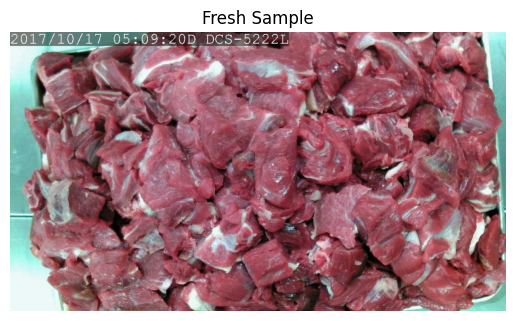

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Örnek olarak Fresh klasöründen bir görsel alalım
img_folder = "meat_quality_dataset/Fresh"
img_name = os.listdir(img_folder)[0]
img_path = os.path.join(img_folder, img_name)

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")
plt.title("Fresh Sample")
plt.show()


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# === 1. Kaynak ve hedef klasör yolları ===
source_dir = "meat_quality_dataset"
target_base = "meat_split_dataset"
classes = ["Fresh", "Spoiled"]

train_dir = os.path.join(target_base, "train")
test_dir = os.path.join(target_base, "test")

# === 2. Hedef klasörleri oluştur ===
for split_dir in [train_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# === 3. Her sınıf için görselleri ayır ve kopyala ===
for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    all_images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Train/test split (%80 train, %20 test)
    train_imgs, test_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

    # Kopyalama işlemi
    for img in train_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("✅ Train/Test klasörleri başarıyla oluşturuldu.")

# === 4. Görsel sayılarını yazdır ===
def count_images(folder):
    total = 0
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{folder}/{cls} klasöründe {num_images} görsel var.")
        total += num_images
    return total

print("\n🔍 Görsel Sayısı:")
train_total = count_images(train_dir)
test_total = count_images(test_dir)

print(f"\n📊 Toplam: Train={train_total} | Test={test_total} | Toplam={train_total + test_total}")


✅ Train/Test klasörleri başarıyla oluşturuldu.

🔍 Görsel Sayısı:
meat_split_dataset/train/Fresh klasöründe 758 görsel var.
meat_split_dataset/train/Spoiled klasöründe 758 görsel var.
meat_split_dataset/test/Fresh klasöründe 190 görsel var.
meat_split_dataset/test/Spoiled klasöründe 190 görsel var.

📊 Toplam: Train=1516 | Test=380 | Toplam=1896


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
train_dir = "meat_split_dataset/train"
test_dir = "meat_split_dataset/test"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 1516 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4853 - loss: 1.2014 - val_accuracy: 0.5000 - val_loss: 0.6611
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6739 - loss: 0.5808 - val_accuracy: 0.7605 - val_loss: 0.4726
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8908 - loss: 0.2699 - val_accuracy: 0.8474 - val_loss: 0.2793
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9193 - loss: 0.2079 - val_accuracy: 0.8816 - val_loss: 0.2024
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 994ms/step - accuracy: 0.9425 - loss: 0.1449 - val_accuracy: 0.9447 - val_loss: 0.1111
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9243 - loss: 0.1727 - val_accuracy: 0.9132 - val_loss: 0.1579
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9351 - loss: 0.1682 - val_accuracy: 0.9895 - val_loss: 0.0482
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9332 - loss: 0.1470 - val_accuracy: 0.9789 - val_lo

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 570ms/step - accuracy: 0.9944 - loss: 0.0327
Test Accuracy: 0.99


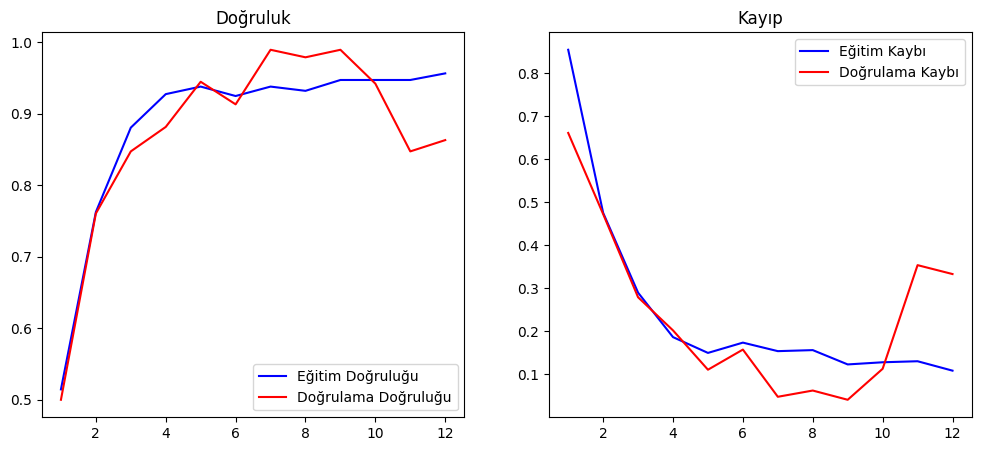

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Eğitim Doğruluğu')
plt.plot(epochs, val_acc, 'r', label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'r', label='Doğrulama Kaybı')
plt.title('Kayıp')
plt.legend()
plt.show()


In [ ]:
model.save("meat_quality_cnn_model.h5")
print("🎉 Model başarıyla meat_quality_cnn_model.h5 olarak kaydedildi.")

🎉 Model başarıyla meat_quality_cnn_model.h5 olarak kaydedildi.


In [ ]:
import pandas as pd

# Eğitim geçmişinden tablo oluştur
history_df = pd.DataFrame(history.history)
history_df.index += 1  # Epoch numarası 1'den başlasın
history_df.index.name = "Epoch"

# Tabloyu yazdır (şık konsol görünümü)
print("📊 Eğitim Sonuçları (Epoch Bazlı):\n")
print(history_df.round(4).to_string())


📊 Eğitim Sonuçları (Epoch Bazlı):

       accuracy    loss  val_accuracy  val_loss
Epoch                                          
1        0.5145  0.8543        0.5000    0.6611
2        0.7625  0.4755        0.7605    0.4726
3        0.8806  0.2901        0.8474    0.2793
4        0.9274  0.1868        0.8816    0.2024
5        0.9380  0.1501        0.9447    0.1111
6        0.9248  0.1740        0.9132    0.1579
7        0.9380  0.1542        0.9895    0.0482
8        0.9321  0.1566        0.9789    0.0627
9        0.9472  0.1234        0.9895    0.0412
10       0.9472  0.1284        0.9421    0.1132
11       0.9472  0.1308        0.8474    0.3540
12       0.9565  0.1089        0.8632    0.3333


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Modeli yükle
model = load_model("meat_quality_cnn_model.h5")

# Test klasörü
test_root = "meat_split_dataset/test"
classes = ["Fresh", "Spoiled"]

# Tüm görselleri topla (tam yol + etiket)
image_paths = []
for cls in classes:
    folder = os.path.join(test_root, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in images:
        image_paths.append((os.path.join(folder, img), cls))

# Rastgele 10 tanesini seç
sample_paths = random.sample(image_paths, 10)

# Sonuçları tut
results = []

for path, true_label in sample_paths:
    img = Image.open(path).convert("RGB")
    img_resized = img.resize((128, 128))
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    pred_label = "Fresh" if prediction[0][0] < 0.5 else "Spoiled"
    confidence = prediction[0][0] if pred_label == "Spoiled" else 1 - prediction[0][0]

    results.append({
        "Dosya": os.path.basename(path),
        "Gerçek Etiket": true_label,
        "Tahmin": pred_label,
        "Güven": round(confidence, 2),
        "Doğru mu?": "✅" if pred_label == true_label else "❌"
    })

# Tablo olarak göster
df_results = pd.DataFrame(results)
print("🔍 10 Rastgele Test Görseli Tahmini:\n")
display(df_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
🔍 10 Rastgele Test Görseli Tahmini:



,Dosya,Gerçek Etiket,Tahmin,Güven,Doğru mu?
0,test_20171017_023721D.jpg,Fresh,Fresh,1.00,✅
1,test_20171017_011521D.jpg,Fresh,Fresh,1.00,✅
2,test_20171018_220521D.jpg,Spoiled,Spoiled,1.00,✅
3,test_20171017_131321D.jpg,Fresh,Fresh,0.90,✅
4,test_20171016_121321D.jpg,Fresh,Fresh,0.98,✅
5,test_20171016_143121D.jpg,Fresh,Fresh,1.00,✅
6,test_20171017_130921D.jpg,Fresh,Fresh,0.91,✅
7,test_20171016_122921D.jpg,Fresh,Fresh,0.99,✅
8,test_20171018_173721D.jpg,Spoiled,Spoiled,1.00,✅
9,test_20171018_003521D.jpg,Spoiled,Spoiled,0.99,✅


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


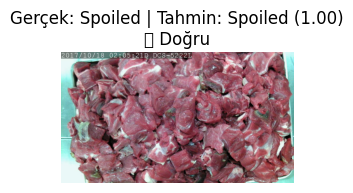

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


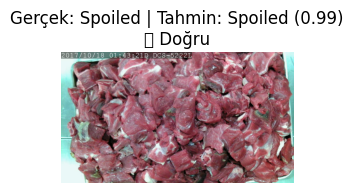

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


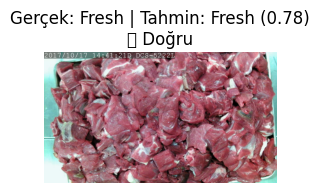

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


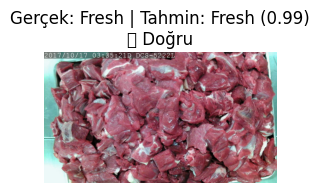

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


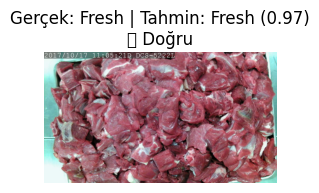

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


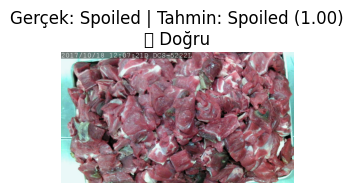

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


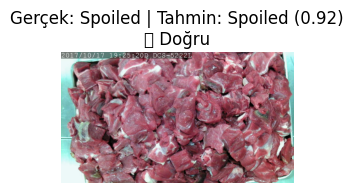

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


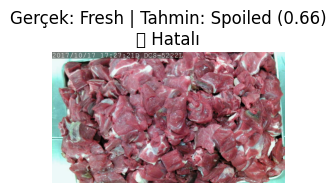

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


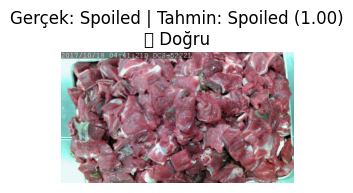

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


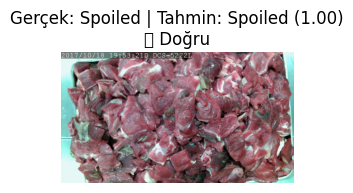

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Modeli yükle
model = load_model("meat_quality_cnn_model.h5")

# Test verileri
test_root = "meat_split_dataset/test"
classes = ["Fresh", "Spoiled"]

# Görsel yollarını topla
image_paths = []
for cls in classes:
    folder = os.path.join(test_root, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in images:
        image_paths.append((os.path.join(folder, img), cls))

# 10 rastgele örnek
sample_paths = random.sample(image_paths, 10)

# Hepsini sırayla çiz
for path, true_label in sample_paths:
    img = Image.open(path).convert("RGB")
    img_resized = img.resize((128, 128))
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    pred_label = "Fresh" if prediction[0][0] < 0.5 else "Spoiled"
    confidence = prediction[0][0] if pred_label == "Spoiled" else 1 - prediction[0][0]
    correct = (true_label == pred_label)

    # Görseli göster
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Gerçek: {true_label} | Tahmin: {pred_label} ({confidence:.2f})\n{'✅ Doğru' if correct else '❌ Hatalı'}")
    plt.show()